# Курсовая работа

## Гапбаев Герман ПМ22-4

### Тема: предварительный анализ данных и построение признаков в задачах классификации текстов

Цель работы:  исследовать различные методы предварительной обработки текстовых данных и построения признаков для решения задачи классификации текстов на примере набора данных IMDB.

Актуальность: классификация текстов является одной из важнейших задач в области обработки естественного языка (NLP) и машинного обучения. Она находит применение в различных сферах, таких как анализ тональности отзывов, фильтрация спама, категоризация новостей и многое другое. Предварительная обработка данных и построение информативных признаков играют ключевую роль в повышении точности моделей классификации текстов.

## Импорты необходимых библиотек

In [1]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import chardet
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
import re
from nltk import ngrams
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform

## Загрузка датасета и получение информации о нем

Для начала необходимо выяснить кодировку датасета

In [2]:
with open('imdb_tr.csv', 'rb') as f:
    result = chardet.detect(f.read())
print(result['encoding'], result['confidence'])

ISO-8859-1 0.7277781191559043


Это значит, что вероятностью примерно 0.73 кодировка датасета - ISO-8859-1

Далее считываем файл с нужной кодировкой и выводим первые 5 строк

In [3]:
data = pd.read_csv('imdb_tr.csv', encoding='iso-8859-1')
# Вывод первых пяти строк данных
print(data.head())

   row_Number                                               text  polarity
0        2148  first think another Disney movie, might good, ...         1
1       23577  Put aside Dr. House repeat missed, Desperate H...         0
2        1319  big fan Stephen King's work, film made even gr...         1
3       13358  watched horrid thing TV. Needless say one movi...         0
4        9495  truly enjoyed film. acting terrific plot. Jeff...         1


Столбец text - содержение отзыва, а polarity - принимает значение 0 (негативный) или 1 (положительный)

Проверим датасет на пропущенные значения

In [4]:
# Проверка наличия пропущенных значений
print(data.isnull().sum())

row_Number    0
text          0
polarity      0
dtype: int64


В датасете нет пропущенных значений

Выведем некоторые данные о датасете

Количество отзывов: 25000
1    12500
0    12500
Name: polarity, dtype: int64
Средняя длина отзыва: 933.95108


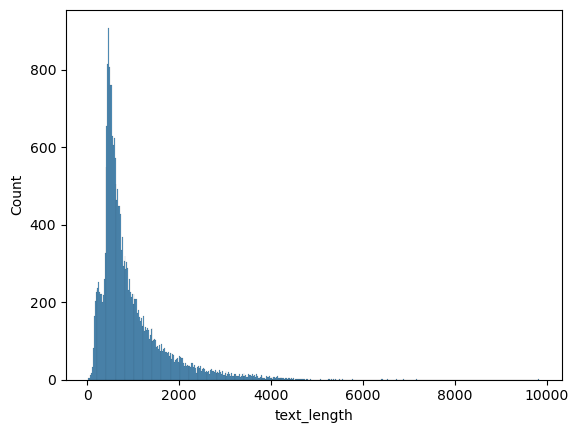

In [5]:
# Размер датасета
print(f"Количество отзывов: {data.shape[0]}")

# Количество положительных и отрицательных отзывов
print(data['polarity'].value_counts())

# Средняя длина отзывов
data['text_length'] = data['text'].apply(len)
print(f"Средняя длина отзыва: {data['text_length'].mean()}")

# Распределение длины отзывов
sns.histplot(data['text_length'], bins=500)
plt.show()

## Предобработка

Проверим какие слова чаще всего встречаются и выведем 20 самых частых

[(',', 275887), ('.', 234828), ('/', 102115), ('>', 102036), ('<', 101971), ('br', 101871), ("'s", 62166), ('movie', 42592), ('film', 38753), (')', 36175), ('(', 35397), ("n't", 33381), ("''", 33101), ('``', 32885), ('it', 29514), ('one', 25891), ('!', 24560), ('like', 19748), ('?', 18465), ('i', 16235)]


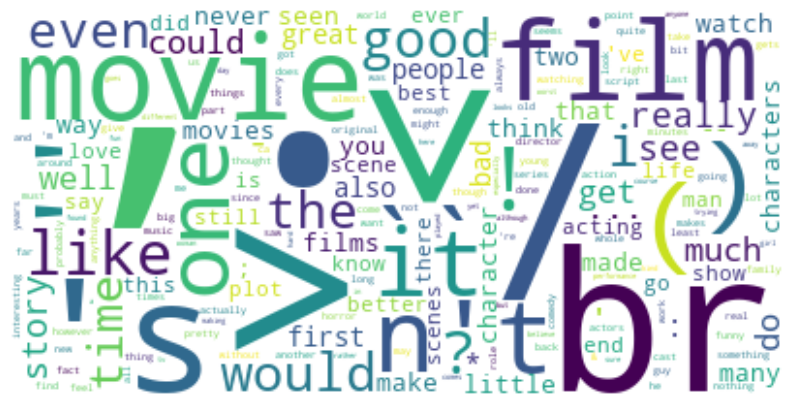

In [6]:
# Анализ частоты встречаемости слов
all_words = []
for text in data['text']:
    all_words.extend(nltk.word_tokenize(text.lower()))

word_counts = Counter(all_words)
print(word_counts.most_common(20))

# Визуализация частоты встречаемости слов (облако слов)

wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Видно, что большая часть слов - незначащие либо знаки препинания. Для получения более достоверной информации, необходимо от них избавиться

In [7]:
# Загрузка стоп-слов для английского языка
stop_words = set(stopwords.words('english'))
stop_words.add('br')

In [8]:
def clean_text(text):
    # Удаление знаков препинания
    text = re.sub(r'[^\w\s]', '', text)
    
    # Токенизация и приведение к нижнему регистру
    tokens = nltk.word_tokenize(text.lower())
    
    # Удаление стоп-слов
    tokens = [token for token in tokens if token not in stop_words]
    
    return tokens

In [9]:
data['clean_text'] = data['text'].apply(clean_text)

# Вывод очищенного текста
print(data['clean_text'].head())

0    [first, think, another, disney, movie, might, ...
1    [put, aside, dr, house, repeat, missed, desper...
2    [big, fan, stephen, kings, work, film, made, e...
3    [watched, horrid, thing, tv, needless, say, on...
4    [truly, enjoyed, film, acting, terrific, plot,...
Name: clean_text, dtype: object


Также необходимо преобразовать все слова в их начальную форму (лемму), для того чтобы одно и то же слово в разных формах не воспринимались программой как разные слова

In [10]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

data['clean_text'] = data['clean_text'].apply(lemmatize_text)

# Вывод лемматизированного текста
print(data['clean_text'].head())

0    [first, think, another, disney, movie, might, ...
1    [put, aside, dr, house, repeat, missed, desper...
2    [big, fan, stephen, king, work, film, made, ev...
3    [watched, horrid, thing, tv, needle, say, one,...
4    [truly, enjoyed, film, acting, terrific, plot,...
Name: clean_text, dtype: object


In [11]:
data['clean_text_str'] = data['clean_text'].apply(lambda x: ' '.join(x))
data['clean_text_str'].head()

0    first think another disney movie might good ki...
1    put aside dr house repeat missed desperate hou...
2    big fan stephen king work film made even great...
3    watched horrid thing tv needle say one movie w...
4    truly enjoyed film acting terrific plot jeff c...
Name: clean_text_str, dtype: object

Уберем слова с нейтральной тональностью

In [12]:
sia = SentimentIntensityAnalyzer()

def filter_neutral_words(text):
    words = text.split()
    filtered_words = [word for word in words if sia.polarity_scores(word)['neu'] != 1]
    return ' '.join(filtered_words)

# Применяем функцию к столбцу с текстами
data['clean_text_str'] = data['clean_text_str'].apply(filter_neutral_words)
data['clean_text'] = data['clean_text_str'].apply(lambda x: x.split())

data['clean_text_str'].head()

0    good help enjoy love 8 love superb play better...
1    missed desperate want fame stable suspect good...
2    fan greater fan happy played evil kind problem...
3    horrid worse lower lame stereotype creating ba...
4    truly enjoyed terrific talent death interestin...
Name: clean_text_str, dtype: object

Теперь можно корректно узнать самые часто встречающиеся слова

[('like', 20104), ('good', 14609), ('well', 9480), ('great', 8924), ('bad', 8912), ('love', 6633), ('best', 6269), ('better', 5548), ('want', 4969), ('play', 4343), ('u', 4077), ('funny', 4072), ('pretty', 3638), ('comedy', 3438), ('horror', 3437), ('original', 3358), ('fan', 3224), ('friend', 3107), ('interesting', 3052), ('kind', 2924)]


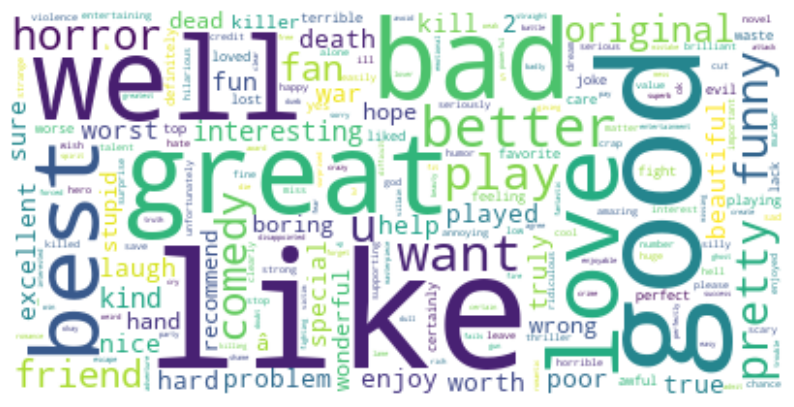

In [13]:
all_words = []
for text in data['clean_text']:
    all_words.extend(text)

word_counts = Counter(all_words)
print(word_counts.most_common(20))

# Обновление облака слов
wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Построение признаков

Построим биграммы, которые могут помочь в анализе тональности

In [14]:
def generate_ngrams(text, n):
    return list(ngrams(text, n))

# Генерация биграмм (n=2)
data['bigrams'] = data['clean_text'].apply(lambda x: generate_ngrams(x, 2))

# Вывод биграмм
print(data['bigrams'].head())

0    [(good, help), (help, enjoy), (enjoy, love), (...
1    [(missed, desperate), (desperate, want), (want...
2    [(fan, greater), (greater, fan), (fan, happy),...
3    [(horrid, worse), (worse, lower), (lower, lame...
4    [(truly, enjoyed), (enjoyed, terrific), (terri...
Name: bigrams, dtype: object


Проведем анализ тональности каждого отзыва

In [15]:
def analyze_sentiment(text):
    return sia.polarity_scores(text)

data['sentiment'] = data['text'].apply(analyze_sentiment)

# Вывод результатов анализа тональности
for i in range(5):
    print(data['sentiment'][i]) 

{'neg': 0.127, 'neu': 0.508, 'pos': 0.365, 'compound': 0.9648}
{'neg': 0.095, 'neu': 0.72, 'pos': 0.185, 'compound': 0.8423}
{'neg': 0.16, 'neu': 0.63, 'pos': 0.209, 'compound': 0.8896}
{'neg': 0.225, 'neu': 0.617, 'pos': 0.158, 'compound': -0.7725}
{'neg': 0.091, 'neu': 0.699, 'pos': 0.211, 'compound': 0.8319}


Neg - процент слов с негативной тональностью   
Neu - с нейтральной   
Pos - с позитивной   
Compound - совокупный показатель тональности отзыва

Визуализируем тональность отзыва с помощью гистограммы

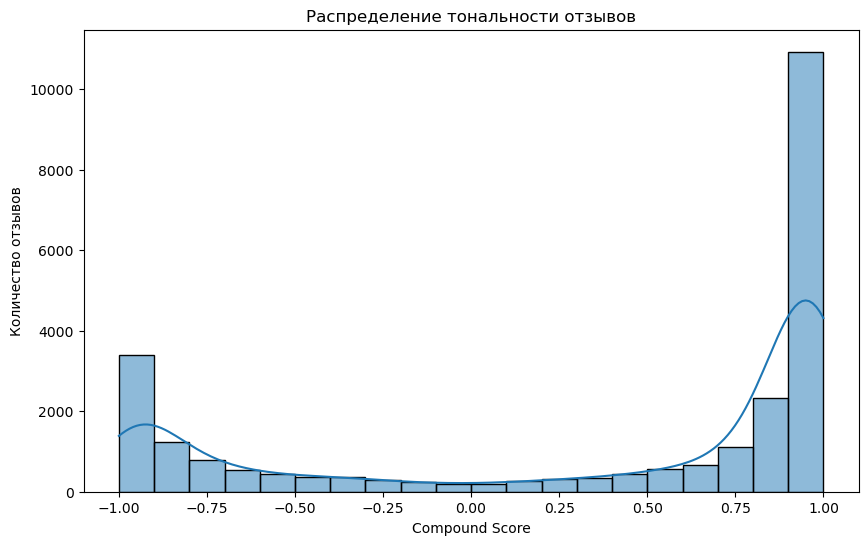

In [16]:
# Анализ тональности
data['compound_score'] = data['sentiment'].apply(lambda x: x['compound'])

# Гистограмма распределения тональности
plt.figure(figsize=(10, 6))
sns.histplot(data['compound_score'], bins=20, kde=True)
plt.xlabel("Compound Score")
plt.ylabel("Количество отзывов")
plt.title("Распределение тональности отзывов")
plt.show()

Проверим взаимосвязь между длиной отзыва и его показателем тональности

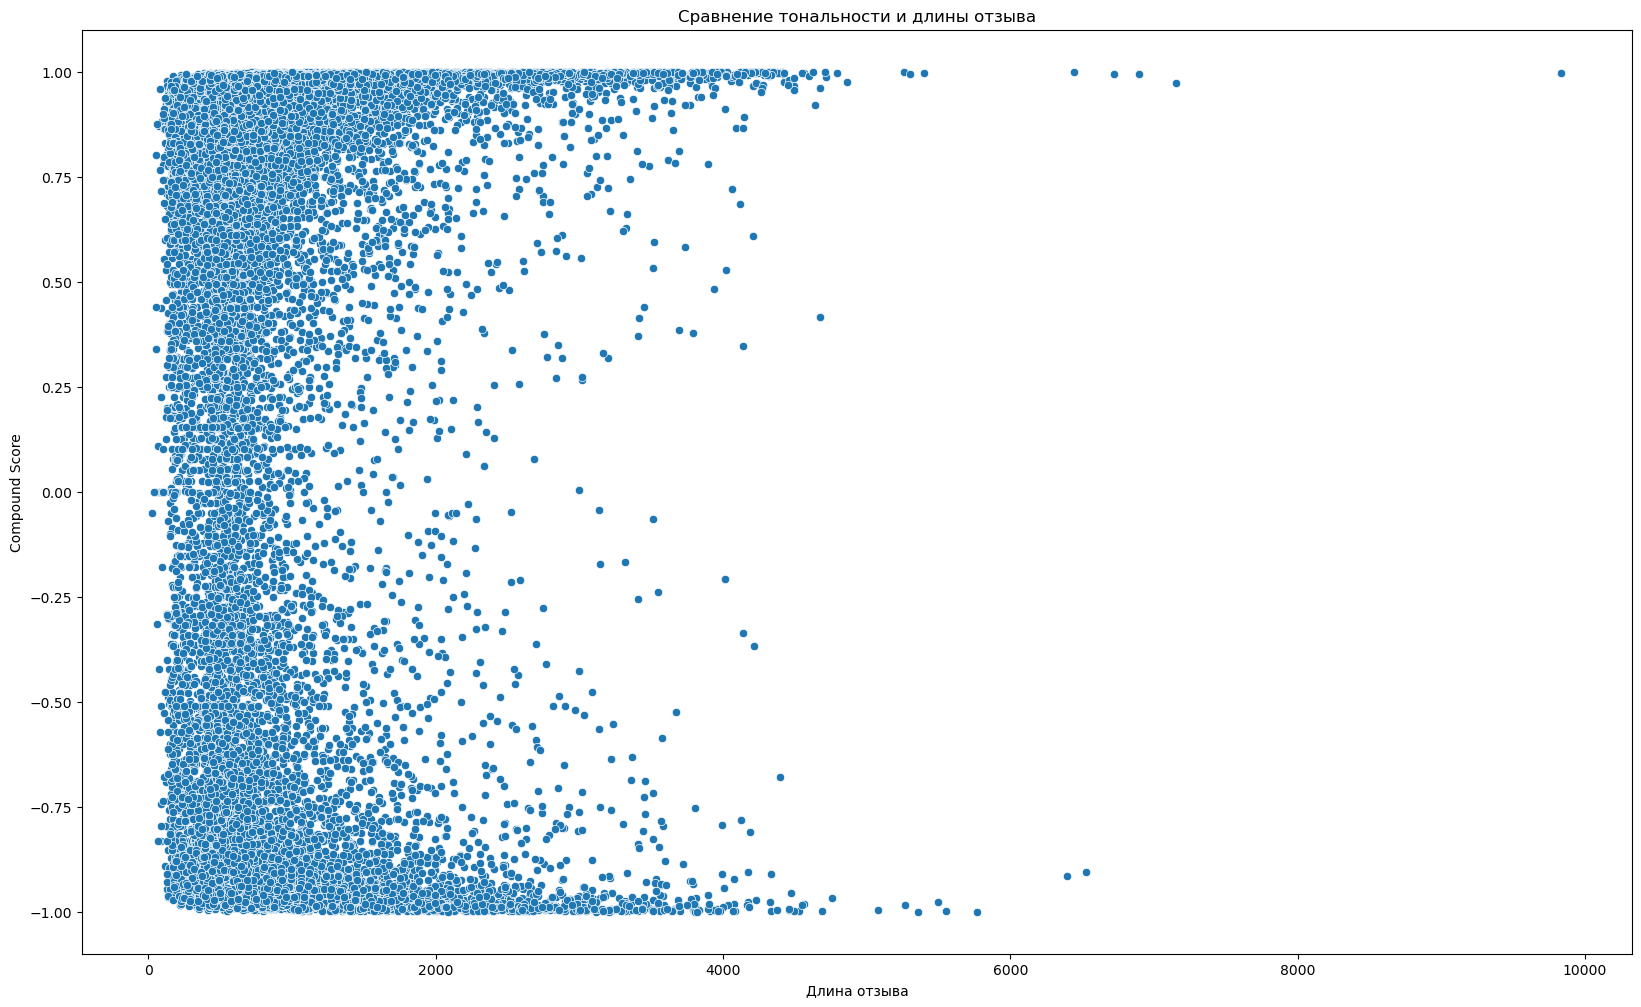

In [17]:
# Scatter plot для сравнения тональности и длины отзыва
plt.figure(figsize=(20, 12))
sns.scatterplot(x='text_length', y='compound_score', data=data)
plt.xlabel("Длина отзыва")
plt.ylabel("Compound Score")
plt.title("Сравнение тональности и длины отзыва")
plt.show()

Четкая взаимосвязь не прослеживается. Длина отзыва не влияет на тональность

Перейдем к векторизации текста с помощью метода "мешок слов".   
Данный метод считает количество уникальных слов в предоставленном тексте и, не учитывая порядок, показывает, сколько раз некоторое слово встретилось в заданном промежутке

In [18]:
vectorizer = CountVectorizer()
bow_matrix = vectorizer.fit_transform(data['clean_text_str'])

# Вывод матрицы bag-of-words
print(bow_matrix.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Строки: Каждая строка соответствует отзыву из датасета.   
Столбцы: Каждый столбец соответствует слову из словаря, созданного CountVectorizer.   
Значения: Число в ячейке [i, j] указывает, сколько раз слово j встречается в отзыве i.

Построим тепловую карту для 100 самых частых слов 

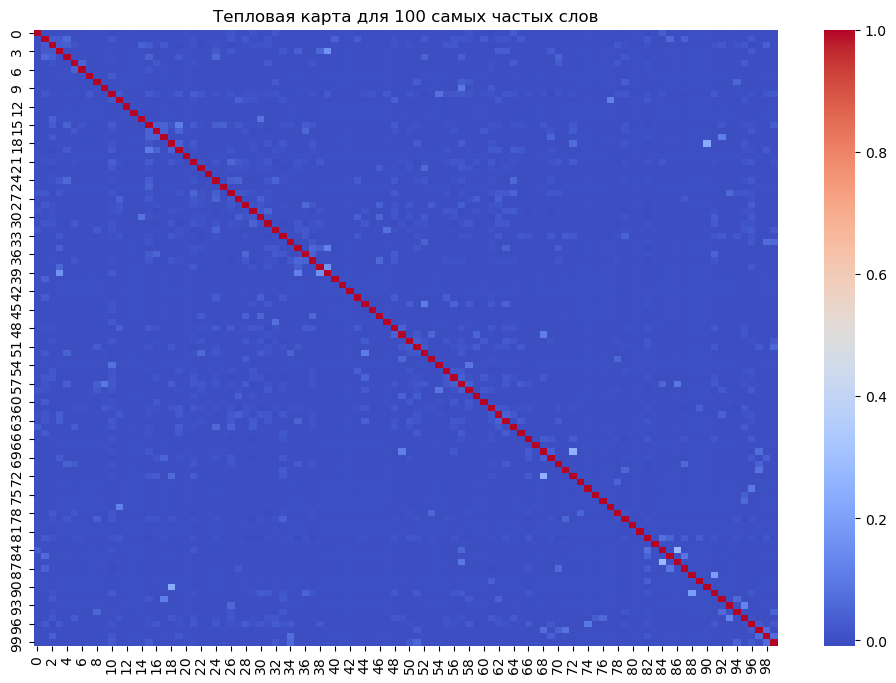

In [19]:
# Выбор 100 самых частых слов
N = 100
top_words = vectorizer.get_feature_names_out()[:N]

# Подматрица bow для 100 самых частых слов
bow_top = bow_matrix[:, :N].toarray()

# Матрица корреляции
corr_matrix_top = pd.DataFrame(bow_top).corr()

# Тепловая карта
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_top, cmap='coolwarm')
plt.title("Тепловая карта для 100 самых частых слов")
plt.show()

Кроме диагональной линии, на карте практически нет других областей с заметной корреляцией. Большая часть графика имеет синий цвет, что указывает на низкую или нулевую корреляцию между словами. То есть корреляция между словами в целом низкая

Теперь проведем векторизацию текста с помощью метода TF-IDF   
Метод отличается тем, что он подсчитывает не только насколько часто некоторое слово встречается в заданном промежутке, но и учитывает его количество в остальных промежутках. Например возьмем слово X, которое встречается почти во всех отзывах, а значит по нему трудно определить тональность отзыва. Теперь возьмем слово Y, которое есть всего в нескольких отзывах, и по нему уже можно определить. Иными словами слово Y имеет больший вес, что как раз и высчитывает метод TF-IDF

In [20]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(data['clean_text_str'])

# Вывод матрицы TF-IDF
print(tfidf_matrix.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Строки: Каждая строка соответствует отзыву из датасета.   
Столбцы: Каждый столбец соответствует слову из словаря, созданного TfidfVectorizer.   
Значения: Число в ячейке [i, j] указывает вес TF-IDF слова j в отзыве i.

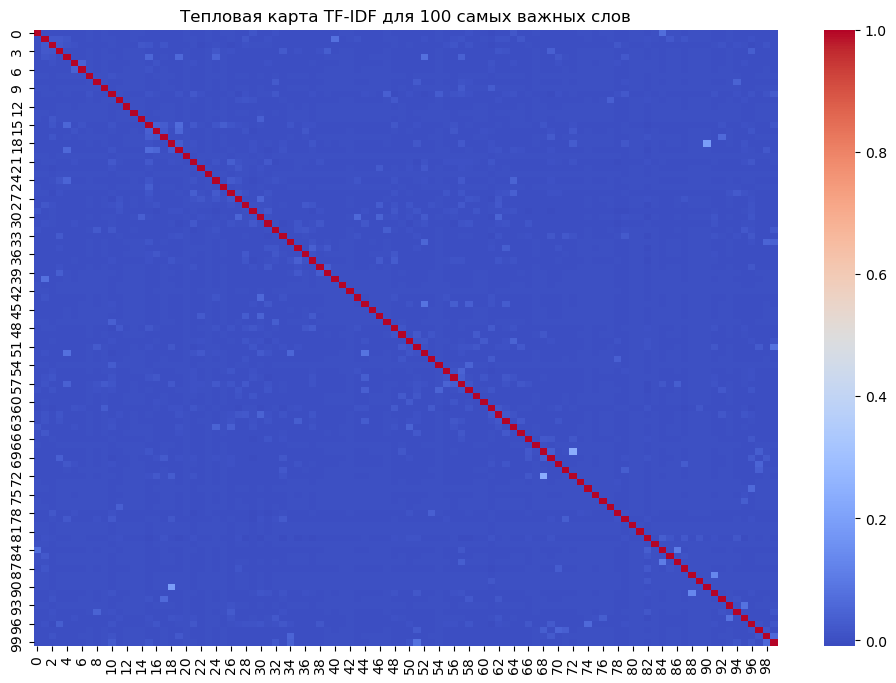

In [21]:
# Выбор 100 самых важных слов
N = 100
top_words = vectorizer.get_feature_names_out()[:N]

# Подматрица TF-IDF для 100 самых важных слов
tfidf_top = tfidf_matrix[:, :N].toarray()

# Матрица корреляции
corr_matrix_tfidf = pd.DataFrame(tfidf_top).corr()

# Тепловая карта
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_tfidf, cmap='coolwarm')
plt.title("Тепловая карта TF-IDF для 100 самых важных слов")
plt.show()

Построим облака слов отдельно для положительных и отрицательных отзывов

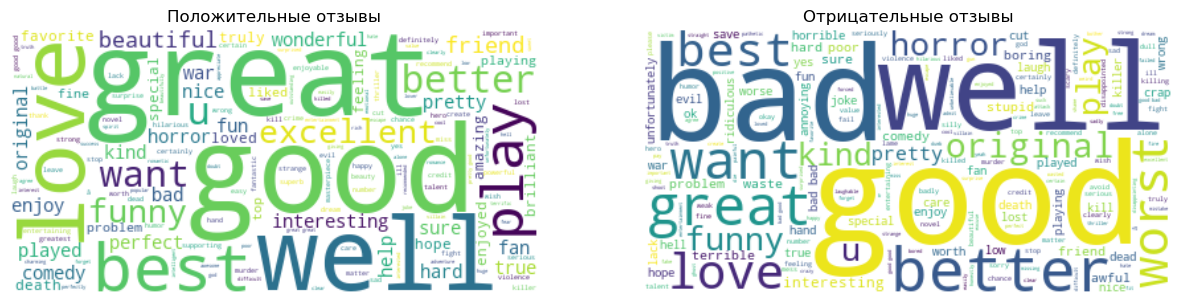

In [22]:
# Разделение данных по категориям
positive_data = data[data['polarity'] == 1]
negative_data = data[data['polarity'] == 0]

# Создание облаков слов
positive_wordcloud = WordCloud(background_color="white").generate(' '.join(positive_data['clean_text_str']))
negative_wordcloud = WordCloud(background_color="white").generate(' '.join(negative_data['clean_text_str']))

# Вывод облаков слов
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Положительные отзывы")

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Отрицательные отзывы")

plt.show()

Построим гистограммы распределения весов TF-IDF для некоторых часто встречающихся слов

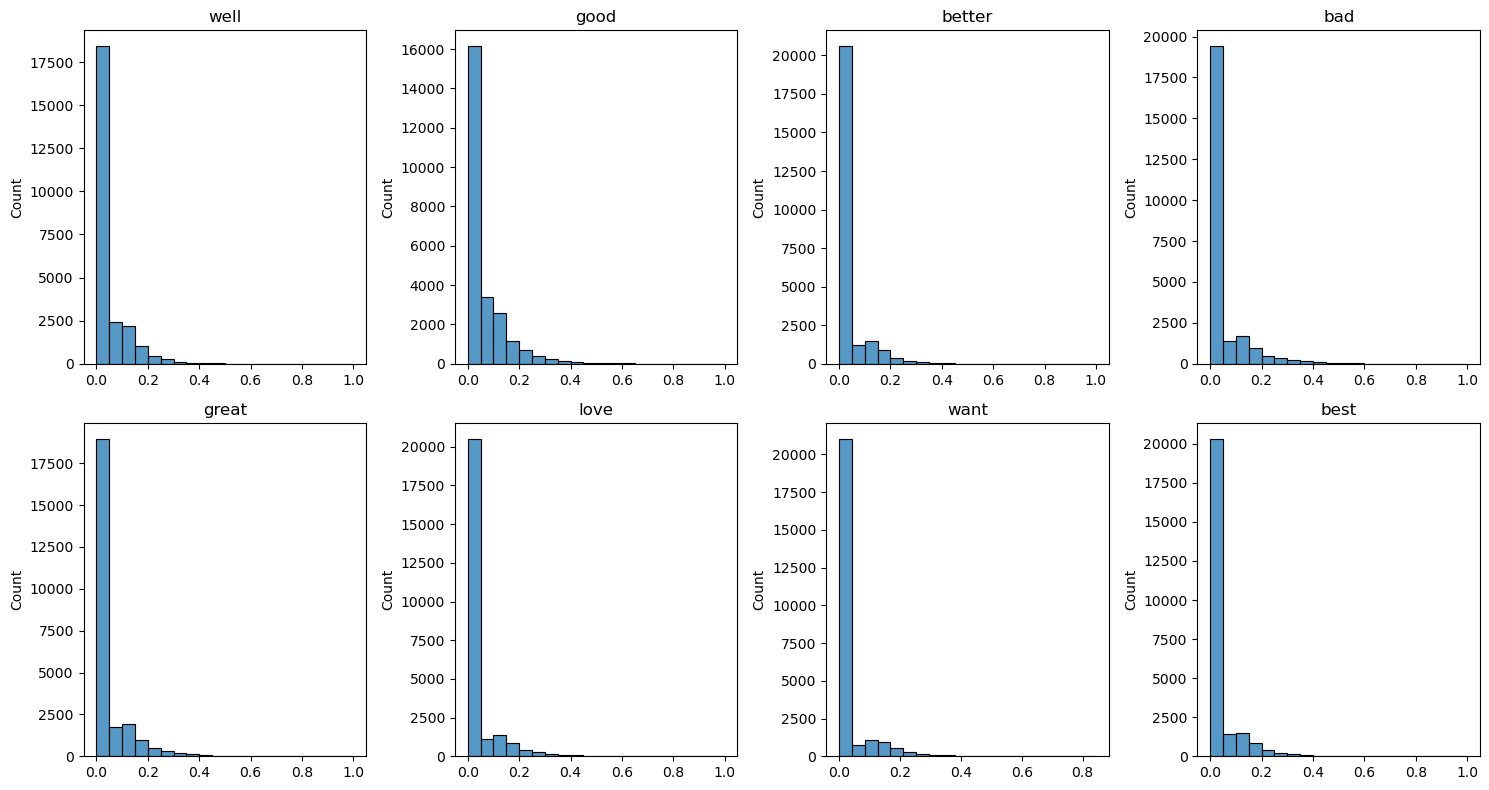

In [23]:
# Выбор нескольких значимых слов
top_words = ['well', 'good', 'better', 'bad', 'great', 'love', 'want', 'best']

# Построение гистограмм
plt.figure(figsize=(15, 8))
for i, word in enumerate(top_words):
    plt.subplot(2, 4, i+1)
    sns.histplot(tfidf_matrix[:, vectorizer.vocabulary_[word]].toarray().flatten(), bins=20)
    plt.title(word)

plt.tight_layout()
plt.show()

Исходя из графиков, можно сделать вывод, что выбранные слова встречаются в большинстве отзывов, независимо от того, положительные они или отрицательные, а значит они не достаточно информативны для того, чтобы определить тональность отзыва

С помощью метода t-SNE на основе TF-IDF векторов визуализируем положительные и отрицательные отзывы.

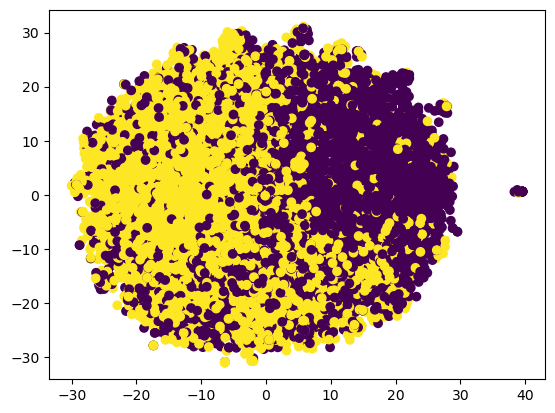

In [24]:
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(tfidf_matrix.toarray())

# Построение графика
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=data['polarity'])
plt.show()

Точки перемешаны, что говорит о том, что метод плохо отражает различия между отзывами

Попробуем метод PCA

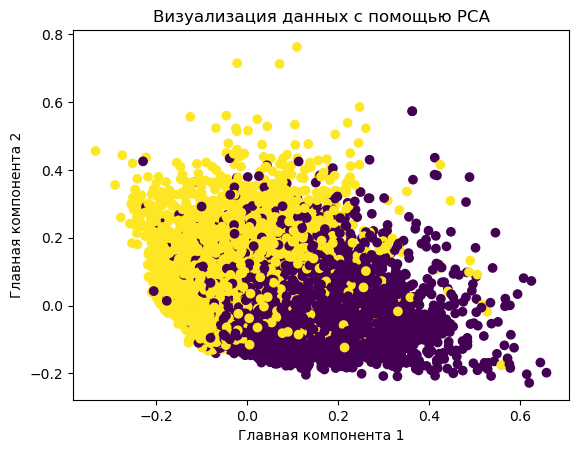

In [25]:
pca = PCA(n_components=2)

# Применяем PCA к матрице TF-IDF
X_embedded = pca.fit_transform(tfidf_matrix.toarray())

# Визуализируем данные в 2D пространстве
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=data['polarity'])
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.title("Визуализация данных с помощью PCA")
plt.show()

Метод сработал лучше, чем предыдущий, но все же точки перемешаны, а значит TF-IDF недостаточно хорошо отражает различия между типами отзывов

## Обучение моделей

Перейдем к обучению и построению моделей для классификации отзывов. Для оценки качества моделей буду использовать метрики Accuracy, Precision, Recall и F1-score. Данные будут разделены на обучающую (80%) и тестовую (20%) выборки.

***Accuracy:*** показывает долю правильных ответов модели среди всех ответов.   
***Precision:*** доля правильно предсказанных положительных отзывов среди всех отзывов, которые модель предсказала как положительные.   
***Recall:*** доля правильно предсказанных положительных отзывов среди всех действительно положительных отзывов.   
***F1-score:*** Гармоническое среднее precision и recall.

Также к каждой модели выведу график ROC-кривой, который показывается соотношение между истинно положительными результатами среди положительных примеров и ложно положительными результатами среди отрицательных примеров. С ее помощью можно оценить, насколько хорошо модель различает два класса. Площадь под ROC-кривой является метрикой, которая количественно оценивает качество модели. ROC = 1 соответствует идеальной модели, ROC = 0.5 - случайной модели.

In [70]:
results = [] # список для сохранения метрик всех моделей

### Логистическая регрессия 

In [91]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, data['polarity'], test_size=0.2)

# Обучения модели логистической регрессии
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred_log = model.predict(X_test)

print(f"Accuracy (LogReg): {accuracy_score(y_test, y_pred_log)}")
print(f"Precision (LogReg): {precision_score(y_test, y_pred_log)}")
print(f"Recall (LogReg): {recall_score(y_test, y_pred_log)}")
print(f"F1-score (LogReg): {f1_score(y_test, y_pred_log)}")

Accuracy (LogReg): 0.8392
Precision (LogReg): 0.8321651090342679
Recall (LogReg): 0.851394422310757
F1-score (LogReg): 0.8416699487987397


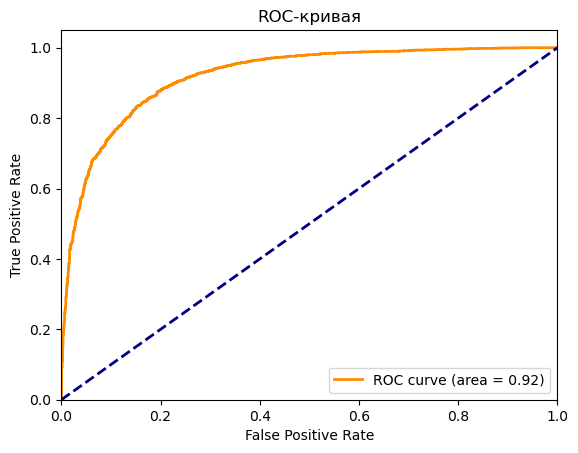

In [92]:
# Вычисляем вероятности классов
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Строим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

results.append({'model': 'LogisticRegression', 
                'accuracy': accuracy_score(y_test, y_pred_log), 
                'precision': precision_score(y_test, y_pred_log), 
                'recall': recall_score(y_test, y_pred_log), 
                'f1': f1_score(y_test, y_pred_log),
                'auc': roc_auc 
              })

### SVC модели 

In [93]:
# Создание и обучение модели SVM
model_svc_linear = SVC(kernel='linear', probability=True)
model_svc_linear.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred_svc_linear = model_svc_linear.predict(X_test)

# Оценка эффективности
print(f"Accuracy (SVM): {accuracy_score(y_test, y_pred_svc_linear)}")
print(f"Precision (SVM): {precision_score(y_test, y_pred_svc_linear)}")
print(f"Recall (SVM): {recall_score(y_test, y_pred_svc_linear)}")
print(f"F1-score (SVM): {f1_score(y_test, y_pred_svc_linear)}")

Accuracy (SVM): 0.8374
Precision (SVM): 0.8333988212180746
Recall (SVM): 0.8450199203187251
F1-score (SVM): 0.8391691394658753


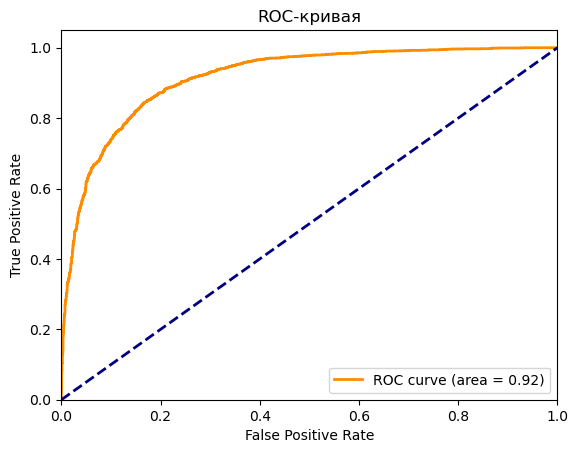

In [94]:
# Вычисляем вероятности классов
y_pred_proba = model_svc_linear.predict_proba(X_test)[:, 1]

# Строим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

results.append({'model': 'SVM linear', 
                'accuracy': accuracy_score(y_test, y_pred_svc_linear), 
                'precision': precision_score(y_test, y_pred_svc_linear), 
                'recall': recall_score(y_test, y_pred_svc_linear), 
                'f1': f1_score(y_test, y_pred_svc_linear),
                'auc': roc_auc 
              })

In [75]:
model_svc_rbf = SVC(kernel='rbf', probability=True)
model_svc_rbf.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred_svc_rbf = model_svc_rbf.predict(X_test)

# Оценка эффективности
print(f"Accuracy (SVM): {accuracy_score(y_test, y_pred_svc_rbf)}")
print(f"Precision (SVM): {precision_score(y_test, y_pred_svc_rbf)}")
print(f"Recall (SVM): {recall_score(y_test, y_pred_svc_rbf)}")
print(f"F1-score (SVM): {f1_score(y_test, y_pred_svc_rbf)}")

Accuracy (SVM): 0.8436
Precision (SVM): 0.8298377522754254
Recall (SVM): 0.856267864434463
F1-score (SVM): 0.8428456591639871


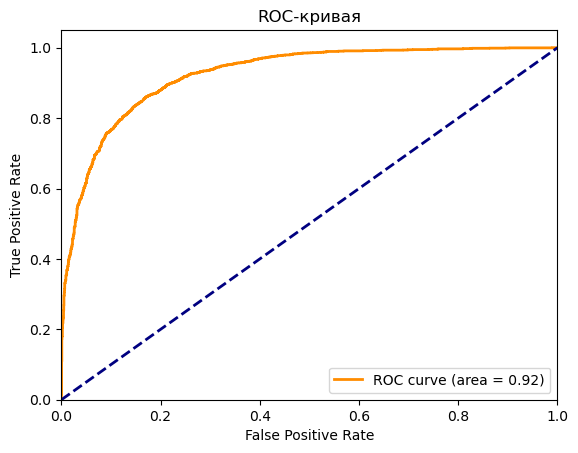

In [76]:
# Вычисляем вероятности классов
y_pred_proba = model_svc_rbf.predict_proba(X_test)[:, 1]

# Строим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

results.append({'model': 'SVM rbf', 
                'accuracy': accuracy_score(y_test, y_pred_svc_rbf), 
                'precision': precision_score(y_test, y_pred_svc_rbf), 
                'recall': recall_score(y_test, y_pred_svc_rbf), 
                'f1': f1_score(y_test, y_pred_svc_rbf),
                'auc': roc_auc 
              })

In [77]:
model_svc_poly = SVC(kernel='poly', probability=True)
model_svc_poly.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred_svc_poly = model_svc_poly.predict(X_test)

# Оценка эффективности
print(f"Accuracy (SVM): {accuracy_score(y_test, y_pred_svc_poly)}")
print(f"Precision (SVM): {precision_score(y_test, y_pred_svc_poly)}")
print(f"Recall (SVM): {recall_score(y_test, y_pred_svc_poly)}")
print(f"F1-score (SVM): {f1_score(y_test, y_pred_svc_poly)}")

Accuracy (SVM): 0.8218
Precision (SVM): 0.7966488956587966
Recall (SVM): 0.8542262147815435
F1-score (SVM): 0.8244334975369458


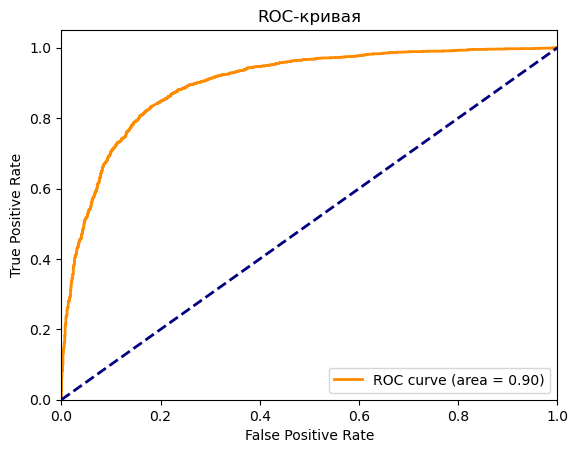

In [78]:
# Вычисляем вероятности классов
y_pred_proba = model_svc_poly.predict_proba(X_test)[:, 1]

# Строим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

results.append({'model': 'SVM poly', 
                'accuracy': accuracy_score(y_test, y_pred_svc_poly), 
                'precision': precision_score(y_test, y_pred_svc_poly), 
                'recall': recall_score(y_test, y_pred_svc_poly), 
                'f1': f1_score(y_test, y_pred_svc_poly),
                'auc': roc_auc 
              })

In [79]:
model_svc_sigm = SVC(kernel='sigmoid', probability=True)
model_svc_sigm.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred_svc_sigm = model_svc_sigm.predict(X_test)

# Оценка эффективности
print(f"Accuracy (SVM): {accuracy_score(y_test, y_pred_svc_sigm)}")
print(f"Precision (SVM): {precision_score(y_test, y_pred_svc_sigm)}")
print(f"Recall (SVM): {recall_score(y_test, y_pred_svc_sigm)}")
print(f"F1-score (SVM): {f1_score(y_test, y_pred_svc_sigm)}")

Accuracy (SVM): 0.8396
Precision (SVM): 0.829005193767479
Recall (SVM): 0.847284605961617
F1-score (SVM): 0.8380452342487885


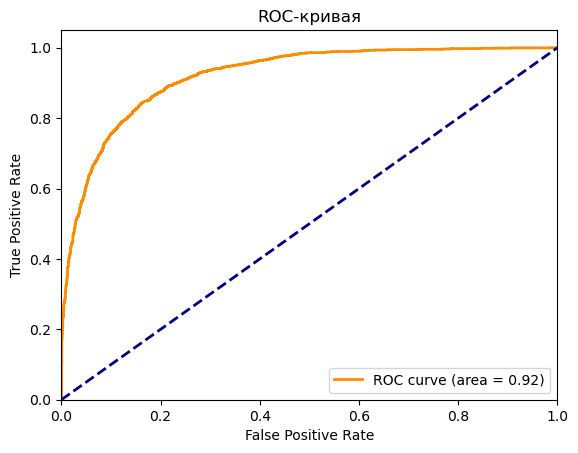

In [80]:
# Вычисляем вероятности классов
y_pred_proba = model_svc_sigm.predict_proba(X_test)[:, 1]

# Строим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

results.append({'model': 'SVM sigm', 
                'accuracy': accuracy_score(y_test, y_pred_svc_sigm), 
                'precision': precision_score(y_test, y_pred_svc_sigm), 
                'recall': recall_score(y_test, y_pred_svc_sigm), 
                'f1': f1_score(y_test, y_pred_svc_sigm),
                'auc': roc_auc 
              })

### Модель наивного Байесовского классификатора

In [81]:
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred_nb = model_nb.predict(X_test)

# Оценка эффективности
print(f"Accuracy (Naive Bayes): {accuracy_score(y_test, y_pred_nb)}")
print(f"Precision (Naive Bayes): {precision_score(y_test, y_pred_nb)}")
print(f"Recall (Naive Bayes): {recall_score(y_test, y_pred_nb)}")
print(f"F1-score (Naive Bayes): {f1_score(y_test, y_pred_nb)}")

Accuracy (Naive Bayes): 0.8342
Precision (Naive Bayes): 0.825824617860016
Recall (Naive Bayes): 0.8383013474887709
F1-score (Naive Bayes): 0.832016210739615


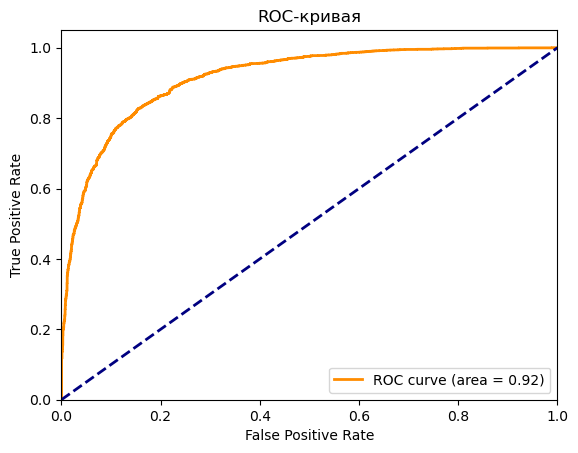

In [82]:
# Вычисляем вероятности классов
y_pred_proba = model_nb.predict_proba(X_test)[:, 1]

# Строим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

results.append({'model': 'Naive Bayes', 
                'accuracy': accuracy_score(y_test, y_pred_nb), 
                'precision': precision_score(y_test, y_pred_nb), 
                'recall': recall_score(y_test, y_pred_nb), 
                'f1': f1_score(y_test, y_pred_nb),
                'auc': roc_auc 
              })

### Модель случайного леса

In [83]:
# Создание и обучение модели случайного леса
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred_rf = model_rf.predict(X_test)

# Оценка эффективности
print(f"Accuracy (Random Forest): {accuracy_score(y_test, y_pred_rf)}")
print(f"Precision (Random Forest): {precision_score(y_test, y_pred_rf)}")
print(f"Recall (Random Forest): {recall_score(y_test, y_pred_rf)}")
print(f"F1-score (Random Forest): {f1_score(y_test, y_pred_rf)}")

Accuracy (Random Forest): 0.8206
Precision (Random Forest): 0.8113964686998395
Recall (Random Forest): 0.8256431196406696
F1-score (Random Forest): 0.8184578020643595


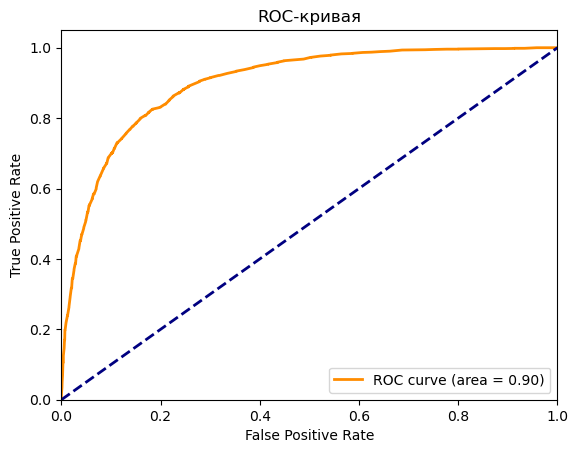

In [84]:
# Вычисляем вероятности классов
y_pred_proba = model_rf.predict_proba(X_test)[:, 1]

# Строим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

results.append({'model': 'Random Forest', 
                'accuracy': accuracy_score(y_test, y_pred_rf), 
                'precision': precision_score(y_test, y_pred_rf), 
                'recall': recall_score(y_test, y_pred_rf), 
                'f1': f1_score(y_test, y_pred_rf),
                'auc': roc_auc 
              })

### Логистическая регрессия с использованием "мешка слов"

In [85]:
X_train_count, X_test_count, y_train, y_test = train_test_split(bow_matrix, data['polarity'], test_size=0.2)

# Обучение моделей с использованием CountVectorizer
model_count = LogisticRegression(max_iter=1000) 
model_count.fit(X_train_count, y_train)
y_pred_count = model_count.predict(X_test_count)

# Оценка эффективности моделей
print(f"Accuracy (CountVectorizer): {accuracy_score(y_test, y_pred_count)}")
print(f"Precision (CountVectorizer): {precision_score(y_test, y_pred_count)}")
print(f"Recall (CountVectorizer): {recall_score(y_test, y_pred_count)}")
print(f"F1-score (CountVectorizer): {f1_score(y_test, y_pred_count)}")

Accuracy (CountVectorizer): 0.8324
Precision (CountVectorizer): 0.8388663967611336
Recall (CountVectorizer): 0.8248407643312102
F1-score (CountVectorizer): 0.8317944600562024


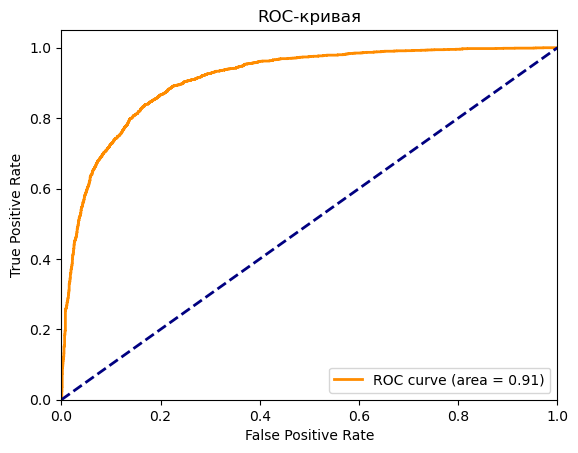

In [86]:
# Вычисляем вероятности классов
y_pred_proba = model_count.predict_proba(X_test_count)[:, 1]

# Строим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

results.append({'model': 'CountVectorizer (LogReg)', 
                'accuracy': accuracy_score(y_test, y_pred_count), 
                'precision': precision_score(y_test, y_pred_count), 
                'recall': recall_score(y_test, y_pred_count), 
                'f1': f1_score(y_test, y_pred_count),
                'auc': roc_auc 
              })

## Сравнение метрик моделей

Для наглядности создам таблицу и диаграммы с метриками всех моделей

                      model  accuracy  precision    recall        f1       auc
0        LogisticRegression    0.8392   0.832165  0.851394  0.841670  0.919149
1                SVM linear    0.8374   0.833399  0.845020  0.839169  0.915427
2                   SVM rbf    0.8436   0.829838  0.856268  0.842846  0.923493
3                  SVM poly    0.8218   0.796649  0.854226  0.824433  0.897985
4                  SVM sigm    0.8396   0.829005  0.847285  0.838045  0.919823
5               Naive Bayes    0.8342   0.825825  0.838301  0.832016  0.915136
6             Random Forest    0.8206   0.811396  0.825643  0.818458  0.899066
7  CountVectorizer (LogReg)    0.8324   0.838866  0.824841  0.831794  0.910833


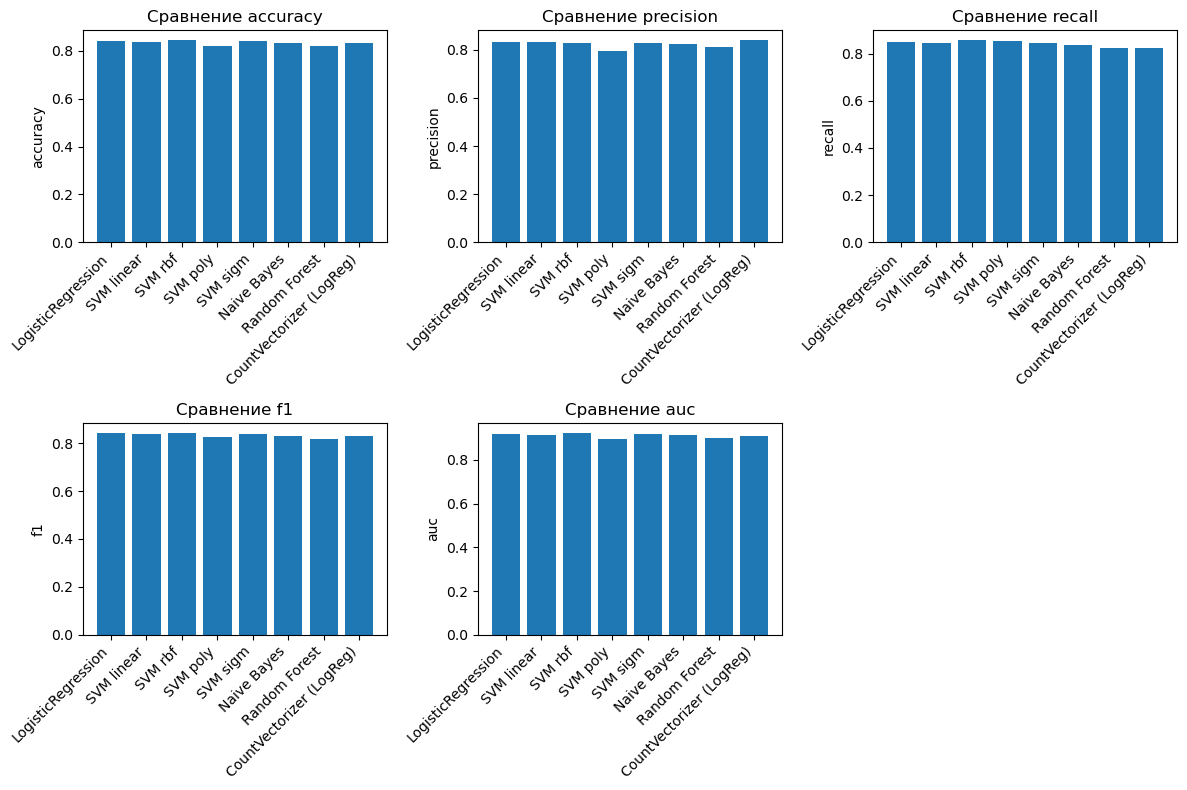

In [95]:
# Создаем DataFrame из списка
results_df = pd.DataFrame(results)

# Выводим таблицу с результатами
print(results_df.to_string())

# Строим график сравнения метрик
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc'] 
plt.figure(figsize=(12, 8)) 

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plt.bar(results_df['model'], results_df[metric])
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Сравнение {metric}")

plt.tight_layout()
plt.show()

***Анализ результатов:***
Модель SVM (RBF) демонстрирует наилучшие результаты по accuracy и AUC, что свидетельствует о ее высокой точности и способности эффективно разделять классы.   
SVM (linear) также демонстрирует высокую точность, незначительно уступая SVM (RBF), и отличается наилучшим значением precision. Это может быть важным преимуществом, если приоритет отдается минимизации ложноположительных результатов.   
SVM (poly) и Random Forest показывают наименее высокие значения по всем метрикам, что говорит об их меньшей эффективности в данной задаче.   
Логистическая регрессия с использованием CountVectorizer показывает неплохие результаты, но уступает варианту с TF-IDF векторизацией.

## Тюнинг гиперпараметров

Для улучшения качества модели, можно попробовать подобрать гиперпараметры. Для модели SVM (RBF) это C и gamma

In [110]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, data['polarity'], test_size=0.2)

# Определение модели
model_rbf = SVC(kernel='rbf', probability = True)

# Определение сетки гиперпараметров
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],
}

# Создание объекта GridSearchCV
grid_search = GridSearchCV(
    estimator=model_rbf,
    param_grid=param_grid,
    scoring='f1',  # Выбираем F1-score как метрику
    cv=3,         # 5-fold кросс-валидация
    n_jobs=-1   
)

# Запуск Grid Search на обучающей выборке
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
print("Лучшие параметры:", grid_search.best_params_)

# Обучение модели с лучшими параметрами
best_model_rbf = grid_search.best_estimator_

# Предсказания на тестовой выборке
y_pred_rbf_best = best_model_rbf.predict(X_test)


Лучшие параметры: {'C': 1, 'gamma': 1}


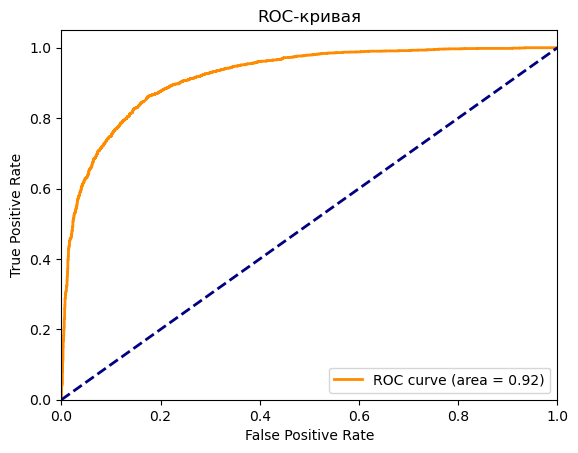

In [111]:
best_model_rbf = SVC(kernel='rbf', C=1, gamma=1, probability=True)
best_model_rbf.fit(X_train, y_train)

# Вычисляем вероятности классов
y_pred_proba = best_model_rbf.predict_proba(X_test)[:, 1]

# Строим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

In [118]:
# Оценка качества модели с лучшими параметрами
print(f"Accuracy (SVM RBF tuned): {accuracy_score(y_test, y_pred_rbf_best)}")
print(f"Precision (SVM RBF tuned): {precision_score(y_test, y_pred_rbf_best)}")
print(f"Recall (SVM RBF tuned): {recall_score(y_test, y_pred_rbf_best)}")
print(f"F1-score (SVM RBF tuned): {f1_score(y_test, y_pred_rbf_best)}")
print(f"ROC (SVM RBF tuned): {roc_auc}")

Accuracy (SVM RBF tuned): 0.8436
Precision (SVM RBF tuned): 0.8355691835952472
Recall (SVM RBF tuned): 0.8606395578365574
F1-score (SVM RBF tuned): 0.8479190976273823
ROC (SVM RBF tuned): 0.9192500101217637


Сравним с метриками модели до тюнинга гиперпараметров

In [115]:
print(*results[2].items(), sep = '\n')

('model', 'SVM rbf')
('accuracy', 0.8436)
('precision', 0.8298377522754254)
('recall', 0.856267864434463)
('f1', 0.8428456591639871)
('auc', 0.9234928807972727)


***Выводы:***   
Accuracy: Обе модели показывают одинаковую точность (Accuracy) - 84.36%.   
ROC AUC: Модель 2 имеет немного лучшее значение площади под ROC-кривой (AUC) - 0.9235 против 0.9193. Это говорит о том, что модель 2 немного лучше разделяет классы.   
Precision/Recall/F1: Модель 1 показывает незначительно лучший Precision (0.8356 vs 0.8298), но немного меньший Recall (0.8606 vs 0.8563) по сравнению с моделью 2. F1-score модели 1 также немного выше.   
В целом, обе модели демонстрируют схожие результаты. Модель 2 имеет небольшое преимущество по AUC, в то время как модель 1 - по Precision.

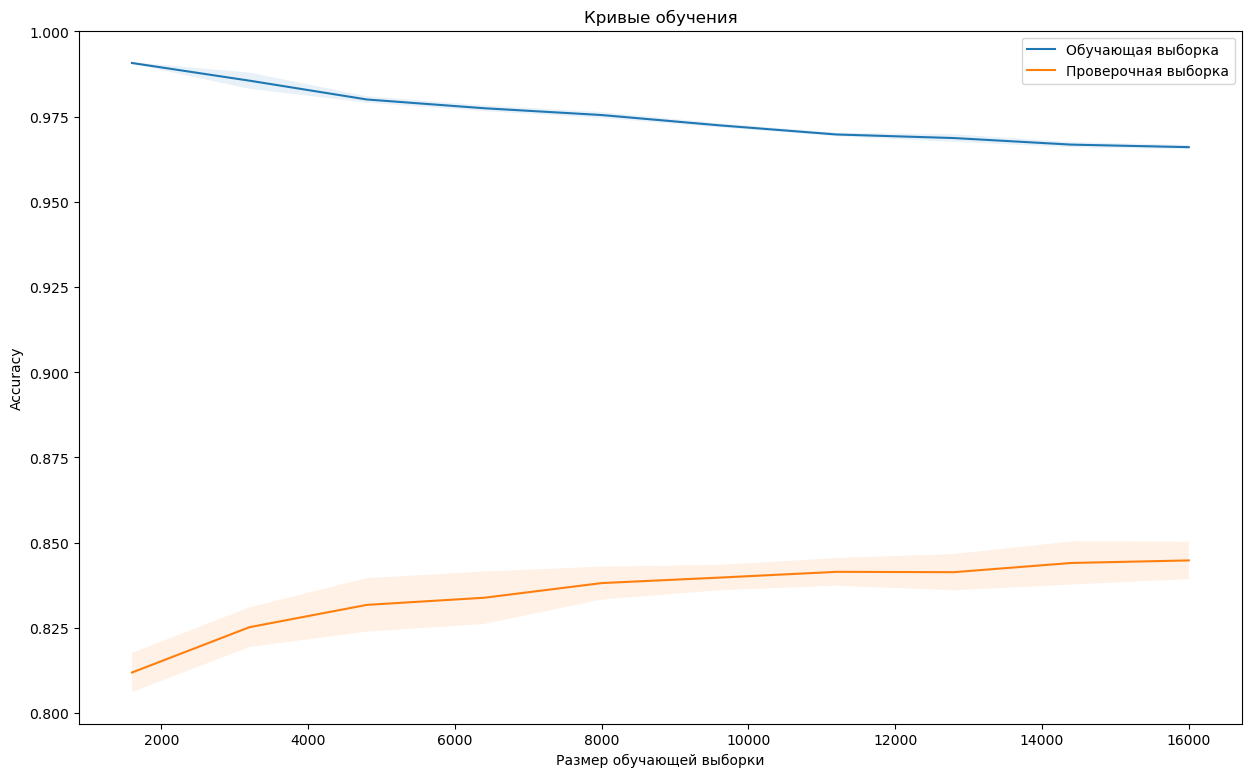

In [121]:
train_sizes = np.linspace(0.1, 1.0, 10)

# Вычисляем кривые обучения 
train_sizes, train_scores, valid_scores = learning_curve(
    model_svc_rbf, X_train, y_train, train_sizes=train_sizes, cv=5, 
    scoring='accuracy', n_jobs=-1  
)

# Вычисляем средние значения и стандартные отклонения
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# Построение графика
plt.figure(figsize=(15, 9))
plt.plot(train_sizes, train_scores_mean, label='Обучающая выборка')
plt.plot(train_sizes, valid_scores_mean, label='Проверочная выборка')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1)
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1)
plt.xlabel("Размер обучающей выборки")
plt.ylabel("Accuracy")
plt.title("Кривые обучения")
plt.legend()
plt.show()

**Интерпретация графика:**   
    ***Синяя линия:*** 
    Показывает accuracy на обучающей выборке. С увеличением размера обучающей выборки accuracy падает, что нормально, так как модель сложнее идеально подстроиться под больший объём данных.   
    ***Оранжевая линия:***   
    Показывает accuracy на проверочной выборке. С увеличением размера обучающей выборки accuracy растёт, но с меньшей скоростью, чем на обучающей выборке. Это говорит о том, что модель обобщает данные и работает на незнакомых данных.   
    ***Зазор между линиями:***    
    Большой разрыв между accuracy на обучающей и проверочной выборке может свидетельствовать о переобучении. В данном случае разрыв не очень большой, что говорит о неплохой обобщающей способности модели.   
**Вывод:**   
Модель демонстрирует хорошую обобщающую способность, о чем свидетельствует рост accuracy на проверочной выборке.   
Увеличение размера обучающей выборки может дальше улучшить accuracy на проверочной выборке, но с меньшей скоростью.   
Нет признаков переобучения.   

## Вывод по проделанной работе

В ходе данной курсовой работы были рассмотрены различные методы предварительной обработки текстов, такие как удаление знаков препинания, стоп-слов, лемматизация, анализ тональности. Были построены признаки с использованием методов Bag-of-Words и TF-IDF. Проведено сравнение различных моделей машинного обучения, таких как логистическая регрессия, SVM с различными ядрами, наивный Байесовский классификатор и случайный лес, для задачи классификации отзывов.   

Результаты исследования:   
1) В ходе исследования было установлено, что правильная предварительная обработка текстов, включающая удаление незначимых символов, стоп-слов и лемматизацию, оказывает существенное влияние на качество моделей классификации.      
2) Сравнение методов векторизации текста показало, что TF-IDF, учитывающий не только частоту слов, но и их информативность в контексте всего корпуса текстов, обеспечивает более высокую точность моделей по сравнению с методом Bag-of-Words.   
   
3) Анализ эффективности различных алгоритмов машинного обучения продемонстрировал, что наилучшие результаты в задаче классификации отзывов IMDB достигаются с помощью модели SVM. При этом выбор ядра оказывает влияние на приоритетные метрики: RBF-ядро обеспечивает максимальную точность и способность разделять классы, в то время как линейное ядро позволяет минимизировать ложноположительные результаты.   
   
4) Тюнинг гиперпараметров модели SVM с RBF-ядром позволил незначительно улучшить её качество.   

5) Исследование кривой обучения подтвердило, что модель SVM, обученная на TF-IDF векторах, обладает хорошей обобщающей способностью и не склонна к переобучению.